This code demonstrates the prediction of stock market price using Recurrent Neural Networks.<br>
Dataset: Infosys stock market price from 2000 to 2008 is used to train the RNN model.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
#import the Keras layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,Dense, Dropout, LSTM, Dropout,Activation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

import os

In [13]:
# Read the dataset 
l = []
for i in os.listdir('files_input'):
    l.append(pd.read_csv(os.path.join('files_input', i)))

data = pd.concat(l, axis = 0) 

In [14]:
data.head()

,Date,Open,High,Low,Close,Shares Traded,Turnover (Rs. Cr)
0,02-Jan-1995,0.0,0.0,0.0,1182.14,-,-
1,03-Jan-1995,0.0,0.0,0.0,1176.82,-,-
2,04-Jan-1995,0.0,0.0,0.0,1163.72,-,-
3,05-Jan-1995,0.0,0.0,0.0,1150.02,-,-
4,06-Jan-1995,0.0,0.0,0.0,1130.36,-,-


In [15]:
# Selecting only Date and Average Price columns
data = data[['Open', 'Close']]

In [16]:
# Scaling the values in the range of 0 to 1
scaler = MinMaxScaler(feature_range = (0, 1))
scaled_price = scaler.fit_transform(data.loc[:, 'Close'].values.reshape(-1, 1))

In [17]:
# Splitting dataset in the ratio of 75:25 for training and test
train_size = int(data.shape[0] * 0.75)
train, test = scaled_price[0:train_size, :], scaled_price[train_size:data.shape[0], :]
print("Number of entries (training set, test set): " + str((len(train), len(test))))

Number of entries (training set, test set): (5324, 1775)


In [18]:
def create_dataset(scaled_price, window_size=1):
    data_X, data_Y = [], []
    for i in range(len(scaled_price) - window_size - 1):
        a = scaled_price[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(scaled_price[i + window_size, 0])
    return(np.array(data_X), np.array(data_Y))

In [19]:
# Create test and training sets for one-step-ahead regression.
window_size = 3
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
print("Original training data shape:")
print(train_X.shape)

# Reshape the input data into appropriate form for Keras.
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
print("New training data shape:")
print(train_X.shape)

Original training data shape:
(5320, 3)
New training data shape:
(5320, 1, 3)


Keras simple RNN is layer is built as the first layer, then  2 dense layers is added.

In [20]:
import tensorflow as tf
model = tf.keras.Sequential([   
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

2022-08-26 17:34:33.903826: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
# Compiling the model
model.compile(loss = "mean_squared_error", optimizer = "adam")

In [22]:
# Training the model
model.fit(train_X, train_Y, epochs=10, batch_size=1)

Epoch 1/10
5320/5320 [==============================] - 14s 2ms/step - loss: 0.0046
Epoch 2/10
5320/5320 [==============================] - 13s 3ms/step - loss: 0.0012
Epoch 3/10
5320/5320 [==============================] - 14s 3ms/step - loss: 0.0011
Epoch 4/10
5320/5320 [==============================] - 14s 3ms/step - loss: 0.0010
Epoch 5/10
5320/5320 [==============================] - 13s 2ms/step - loss: 0.0010
Epoch 6/10
5320/5320 [==============================] - 13s 2ms/step - loss: 0.0010
Epoch 7/10
5320/5320 [==============================] - 13s 2ms/step - loss: 9.8491e-04
Epoch 8/10
5320/5320 [==============================] - 12s 2ms/step - loss: 9.7866e-04
Epoch 9/10
5320/5320 [==============================] - 13s 2ms/step - loss: 9.8151e-04
Epoch 10/10
5320/5320 [==============================] - 13s 2ms/step - loss: 9.8145e-04


In [23]:
def predict_and_score(model, X, Y):
    # Make predictions on the original scale of the data.
    predicted = scaler.inverse_transform(model.predict(X))
    # Prepare Y data to also be on the original scale for interpretability.
    orig_data = scaler.inverse_transform([Y])
    # Calculate RMSE.
    score = np.sqrt(mean_squared_error(orig_data[0], predicted[:, 0]))
    return(score, predicted)


In [24]:
rmse_train, train_predict = predict_and_score(model, train_X, train_Y)
rmse_test, test_predict = predict_and_score(model, test_X, test_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)

56/56 [==============================] - 0s 2ms/step
Training data score: 538.43 RMSE
Test data score: 464.53 RMSE


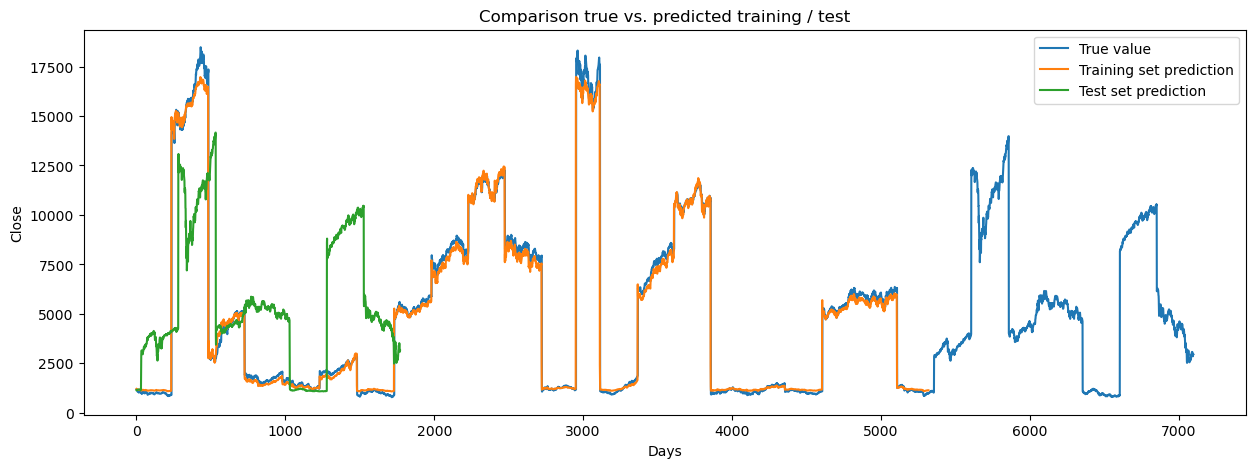

In [26]:
# Create the plot for predicted and the training data.
plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(scaled_price), label = "True value")
plt.plot(train_predict, label = "Training set prediction")
plt.plot(test_predict, label = "Test set prediction")
plt.xlabel("Days")
plt.ylabel("Close")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
plt.show()